# start

from 0320_2; add time features; rmv lang

In [21]:
PRFX='0320_3'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])

params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss'],
    'max_delta_step': 1,
}
num_rounds = 800

['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [2]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [3]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [4]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [5]:
grand_total

150000000.0

In [6]:
grand_total/1e6

150.0

In [7]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-20 16:01:15 chunk 0


In [8]:
df = pd.concat(lst_df)

In [9]:
df.shape

(1000000, 29)

In [10]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

In [11]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [12]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 135 ms, sys: 216 ms, total: 351 ms
Wall time: 351 ms


In [13]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((850000, 25), (150000, 25), (850000, 4), (150000, 4))

# model

In [14]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 16:01:19 Retweet ********************************************************************************
[16:01:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-error:0.11277	train-logloss:0.58841	eval-error:0.11345	eval-logloss:0.58843
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[16:01:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-error:0.11276	train-logloss:0.50519	eval-error:0.11344	eval-logloss:0.50564
[16:01:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-error:0.11274	train-logloss:0.44323	eval-error:0.11341	eval-logloss:0.44376
[16:01:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6


[16:01:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.11169	train-logloss:0.31847	eval-error:0.11259	eval-logloss:0.32326
[16:01:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.11167	train-logloss:0.31832	eval-error:0.11261	eval-logloss:0.32320
[16:01:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[41]	train-error:0.11167	train-logloss:0.31826	eval-error:0.11259	eval-logloss:0.32320
[16:01:58] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[42]	train-error:0.11165	train-logloss:0.31821	eval-error:0.11261	eval-logloss:0.32320
[16:01:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.11164	train-logloss:0.31815	eva

[16:02:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[79]	train-error:0.11101	train-logloss:0.31402	eval-error:0.11249	eval-logloss:0.32209
[16:02:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[80]	train-error:0.11101	train-logloss:0.31400	eval-error:0.11252	eval-logloss:0.32211
[16:02:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[81]	train-error:0.11099	train-logloss:0.31388	eval-error:0.11251	eval-logloss:0.32211
[16:02:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[82]	train-error:0.11097	train-logloss:0.31381	eval-error:0.11254	eval-logloss:0.32213
[16:02:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[83]	train-error:0.11094	train-logloss:0.31368	eva

[16:03:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[119]	train-error:0.11041	train-logloss:0.31033	eval-error:0.11249	eval-logloss:0.32168
[16:03:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[120]	train-error:0.11040	train-logloss:0.31027	eval-error:0.11249	eval-logloss:0.32168
[16:03:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[121]	train-error:0.11039	train-logloss:0.31013	eval-error:0.11251	eval-logloss:0.32165
[16:03:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[122]	train-error:0.11038	train-logloss:0.31000	eval-error:0.11244	eval-logloss:0.32166
[16:03:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[123]	train-error:0.11035	train-logloss:0.309

[16:03:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[6]	train-error:0.02778	train-logloss:0.17552	eval-error:0.02716	eval-logloss:0.17458
[16:03:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-error:0.02777	train-logloss:0.15546	eval-error:0.02715	eval-logloss:0.15452
[16:03:36] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-error:0.02777	train-logloss:0.14156	eval-error:0.02715	eval-logloss:0.14068
[16:03:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-error:0.02777	train-logloss:0.13214	eval-error:0.02715	eval-logloss:0.13129
[16:03:37] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-error:0.02777	train-logloss:0.12583	eval

[16:04:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[46]	train-error:0.02775	train-logloss:0.11042	eval-error:0.02717	eval-logloss:0.11278
[16:04:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[47]	train-error:0.02775	train-logloss:0.11038	eval-error:0.02717	eval-logloss:0.11278
[16:04:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[48]	train-error:0.02775	train-logloss:0.11028	eval-error:0.02717	eval-logloss:0.11276
[16:04:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[49]	train-error:0.02775	train-logloss:0.11017	eval-error:0.02717	eval-logloss:0.11274
[16:04:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[50]	train-error:0.02775	train-logloss:0.11010	eva

[16:04:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[22]	train-error:0.32764	train-logloss:0.60464	eval-error:0.33218	eval-logloss:0.60866
[16:04:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[23]	train-error:0.32726	train-logloss:0.60425	eval-error:0.33235	eval-logloss:0.60840
[16:04:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[24]	train-error:0.32674	train-logloss:0.60367	eval-error:0.33172	eval-logloss:0.60786
[16:04:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[25]	train-error:0.32601	train-logloss:0.60301	eval-error:0.33120	eval-logloss:0.60730
[16:04:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[26]	train-error:0.32558	train-logloss:0.60259	e

[16:05:12] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[62]	train-error:0.31833	train-logloss:0.59432	eval-error:0.32597	eval-logloss:0.60155
[16:05:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[63]	train-error:0.31833	train-logloss:0.59425	eval-error:0.32595	eval-logloss:0.60148
[16:05:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[64]	train-error:0.31798	train-logloss:0.59401	eval-error:0.32579	eval-logloss:0.60137
[16:05:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[65]	train-error:0.31767	train-logloss:0.59370	eval-error:0.32567	eval-logloss:0.60122
[16:05:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[66]	train-error:0.31761	train-logloss:0.59360	eva

[16:05:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[102]	train-error:0.31221	train-logloss:0.58715	eval-error:0.32257	eval-logloss:0.59746
[16:05:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[103]	train-error:0.31224	train-logloss:0.58697	eval-error:0.32236	eval-logloss:0.59739
[16:05:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[104]	train-error:0.31220	train-logloss:0.58692	eval-error:0.32235	eval-logloss:0.59738
[16:05:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[105]	train-error:0.31211	train-logloss:0.58686	eval-error:0.32229	eval-logloss:0.59735
[16:05:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[106]	train-error:0.31211	train-logloss:0.58683

[16:06:14] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[142]	train-error:0.30865	train-logloss:0.58270	eval-error:0.32102	eval-logloss:0.59563
[16:06:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[143]	train-error:0.30857	train-logloss:0.58260	eval-error:0.32101	eval-logloss:0.59562
[16:06:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[144]	train-error:0.30832	train-logloss:0.58234	eval-error:0.32075	eval-logloss:0.59546
[16:06:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[145]	train-error:0.30806	train-logloss:0.58202	eval-error:0.32065	eval-logloss:0.59520
[16:06:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[146]	train-error:0.30794	train-logloss:0.581

[16:06:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[182]	train-error:0.30489	train-logloss:0.57771	eval-error:0.31877	eval-logloss:0.59287
[16:06:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[183]	train-error:0.30484	train-logloss:0.57764	eval-error:0.31872	eval-logloss:0.59284
[16:06:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[184]	train-error:0.30479	train-logloss:0.57751	eval-error:0.31871	eval-logloss:0.59275
[16:06:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[185]	train-error:0.30468	train-logloss:0.57734	eval-error:0.31828	eval-logloss:0.59270
[16:06:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[186]	train-error:0.30465	train-logloss:0.577

[16:07:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[222]	train-error:0.30187	train-logloss:0.57375	eval-error:0.31757	eval-logloss:0.59167
[16:07:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[223]	train-error:0.30178	train-logloss:0.57364	eval-error:0.31749	eval-logloss:0.59156
[16:07:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[224]	train-error:0.30177	train-logloss:0.57363	eval-error:0.31749	eval-logloss:0.59156
[16:07:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[225]	train-error:0.30167	train-logloss:0.57352	eval-error:0.31746	eval-logloss:0.59157
[16:07:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[226]	train-error:0.30153	train-logloss:0.5734

[16:07:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[262]	train-error:0.29903	train-logloss:0.57054	eval-error:0.31668	eval-logloss:0.59076
[16:07:46] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[263]	train-error:0.29902	train-logloss:0.57052	eval-error:0.31667	eval-logloss:0.59074
[16:07:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[264]	train-error:0.29900	train-logloss:0.57048	eval-error:0.31669	eval-logloss:0.59072
[16:07:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[265]	train-error:0.29897	train-logloss:0.57043	eval-error:0.31660	eval-logloss:0.59067
[16:07:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[266]	train-error:0.29896	train-logloss:0.57041	

[16:08:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[302]	train-error:0.29658	train-logloss:0.56709	eval-error:0.31517	eval-logloss:0.58908
[16:08:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[303]	train-error:0.29654	train-logloss:0.56695	eval-error:0.31511	eval-logloss:0.58896
[16:08:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[304]	train-error:0.29645	train-logloss:0.56684	eval-error:0.31511	eval-logloss:0.58891
[16:08:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[305]	train-error:0.29639	train-logloss:0.56673	eval-error:0.31508	eval-logloss:0.58884
[16:08:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[306]	train-error:0.29637	train-logloss:0.5666

[16:08:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[342]	train-error:0.29376	train-logloss:0.56320	eval-error:0.31457	eval-logloss:0.58818
[16:08:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[343]	train-error:0.29373	train-logloss:0.56313	eval-error:0.31447	eval-logloss:0.58818
[16:08:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[344]	train-error:0.29355	train-logloss:0.56299	eval-error:0.31442	eval-logloss:0.58812
[16:08:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[345]	train-error:0.29343	train-logloss:0.56286	eval-error:0.31431	eval-logloss:0.58805
[16:08:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[346]	train-error:0.29340	train-logloss:0.562

[16:09:17] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[382]	train-error:0.29085	train-logloss:0.55989	eval-error:0.31422	eval-logloss:0.58754
[16:09:18] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[383]	train-error:0.29084	train-logloss:0.55987	eval-error:0.31424	eval-logloss:0.58754
[16:09:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=6
[384]	train-error:0.29079	train-logloss:0.55981	eval-error:0.31425	eval-logloss:0.58757
[16:09:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[385]	train-error:0.29073	train-logloss:0.55973	eval-error:0.31423	eval-logloss:0.58757
[16:09:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[386]	train-error:0.29072	train-logloss:0.55971	

[16:09:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[422]	train-error:0.28844	train-logloss:0.55695	eval-error:0.31404	eval-logloss:0.58719
[16:09:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[423]	train-error:0.28832	train-logloss:0.55684	eval-error:0.31404	eval-logloss:0.58720
[16:09:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[424]	train-error:0.28828	train-logloss:0.55680	eval-error:0.31404	eval-logloss:0.58721
[16:09:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[425]	train-error:0.28824	train-logloss:0.55675	eval-error:0.31397	eval-logloss:0.58719
[16:09:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[426]	train-error:0.28823	train-logloss:0.5567

[16:10:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[462]	train-error:0.28661	train-logloss:0.55448	eval-error:0.31353	eval-logloss:0.58672
[16:10:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[463]	train-error:0.28659	train-logloss:0.55442	eval-error:0.31349	eval-logloss:0.58668
[16:10:20] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[464]	train-error:0.28658	train-logloss:0.55440	eval-error:0.31349	eval-logloss:0.58669
[16:10:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[465]	train-error:0.28657	train-logloss:0.55439	eval-error:0.31353	eval-logloss:0.58669
[16:10:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[466]	train-error:0.28651	train-logloss:0.55435	

[16:10:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[502]	train-error:0.28397	train-logloss:0.55100	eval-error:0.31215	eval-logloss:0.58532
[16:10:51] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[503]	train-error:0.28386	train-logloss:0.55090	eval-error:0.31211	eval-logloss:0.58534
[16:10:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[504]	train-error:0.28383	train-logloss:0.55086	eval-error:0.31214	eval-logloss:0.58536
[16:10:52] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[505]	train-error:0.28380	train-logloss:0.55082	eval-error:0.31220	eval-logloss:0.58536
[16:10:53] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[506]	train-error:0.28377	train-logloss:0.55077

[16:11:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[27]	train-error:0.00778	train-logloss:0.04238	eval-error:0.00759	eval-logloss:0.04312
[16:11:21] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[28]	train-error:0.00778	train-logloss:0.04235	eval-error:0.00759	eval-logloss:0.04313
[16:11:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[29]	train-error:0.00778	train-logloss:0.04224	eval-error:0.00759	eval-logloss:0.04311
[16:11:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[30]	train-error:0.00778	train-logloss:0.04219	eval-error:0.00759	eval-logloss:0.04311
[16:11:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[31]	train-error:0.00778	train-logloss:0.04214	eval

In [15]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


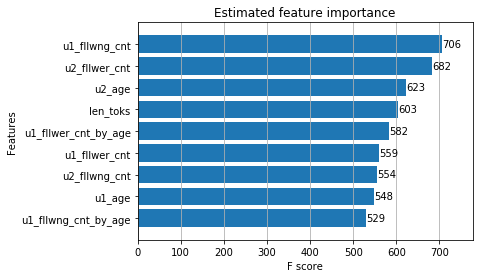

,0,1
8,u1_fllwng_cnt,706
6,u2_fllwer_cnt,682
13,u2_age,623
0,len_toks,603
4,u1_fllwer_cnt_by_age,582
3,u1_fllwer_cnt,559
1,u2_fllwng_cnt,554
14,u1_age,548
2,u1_fllwng_cnt_by_age,529
5,twt_age,507


Reply


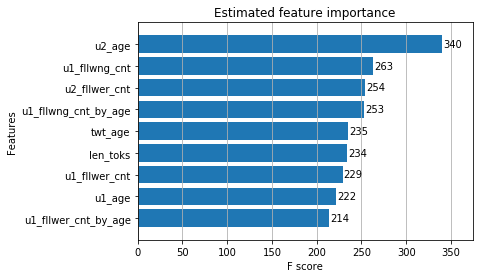

,0,1
0,u2_age,340
7,u1_fllwng_cnt,263
3,u2_fllwer_cnt,254
2,u1_fllwng_cnt_by_age,253
9,twt_age,235
4,len_toks,234
8,u1_fllwer_cnt,229
6,u1_age,222
1,u1_fllwer_cnt_by_age,214
15,u2_fllwng_cnt,207


Like


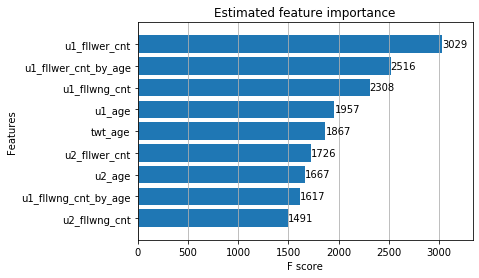

,0,1
5,u1_fllwer_cnt,3029
4,u1_fllwer_cnt_by_age,2516
12,u1_fllwng_cnt,2308
6,u1_age,1957
11,twt_age,1867
9,u2_fllwer_cnt,1726
8,u2_age,1667
2,u1_fllwng_cnt_by_age,1617
10,u2_fllwng_cnt,1491
3,len_toks,1490


RTwCmnt


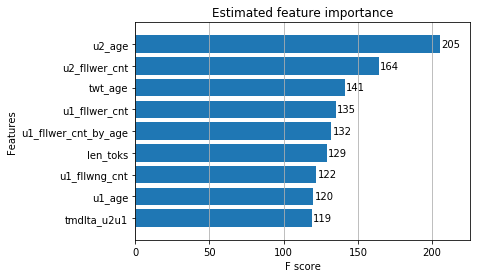

,0,1
0,u2_age,205
1,u2_fllwer_cnt,164
10,twt_age,141
3,u1_fllwer_cnt,135
11,u1_fllwer_cnt_by_age,132
5,len_toks,129
9,u1_fllwng_cnt,122
7,u1_age,120
4,tmdlta_u2u1,119
2,u2_fllwng_cnt,107


In [16]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

## valid

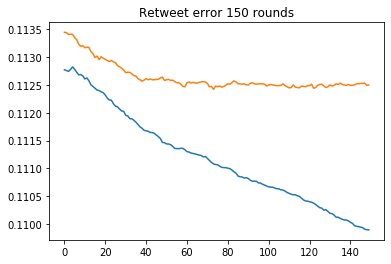

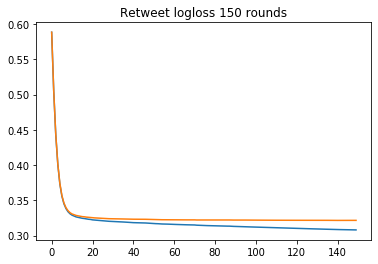

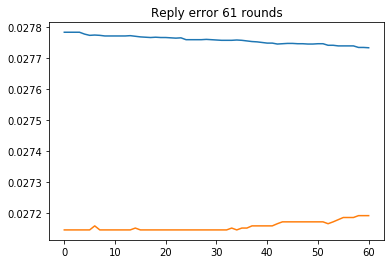

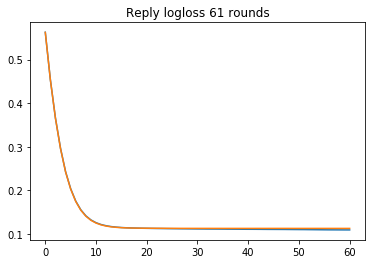

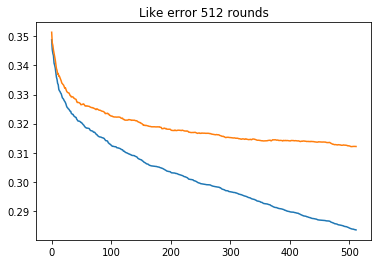

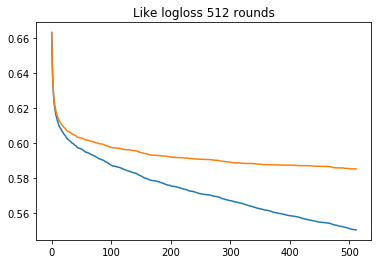

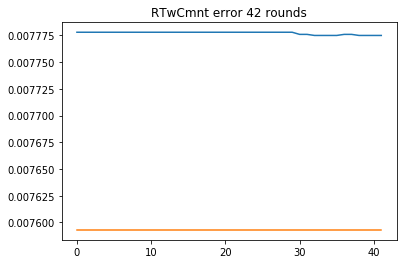

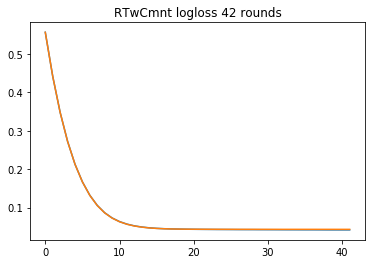

In [17]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()

In [18]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 16:11:36 Retweet
2020-03-20 16:11:37 Reply
2020-03-20 16:11:38 Like
2020-03-20 16:11:42 RTwCmnt


In [19]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7521 valid auc: 0.7157
train prauc: 0.3257 valid auc: 0.2622
train rce: 12.7221 valid rce: 9.0950
Reply
train rocauc: 0.8033 valid auc: 0.7597
train prauc: 0.1370 valid auc: 0.0813
train rce: 13.9688 valid rce: 9.5631
Like
train rocauc: 0.7880 valid auc: 0.7463
train prauc: 0.7463 valid auc: 0.6928
train rce: 19.7303 valid rce: 14.5781
RTwCmnt
train rocauc: 0.7641 valid auc: 0.6742
train prauc: 0.0566 valid auc: 0.0163
train rce: 8.6294 valid rce: 3.4216


In [20]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.325697,12.7221,0.136979,13.9688,0.746328,19.7303,0.0566063,8.62937
scrval,0.262218,9.095,0.0812799,9.56305,0.692805,14.5781,0.0163491,3.42157


# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 37s, sys: 8.76 s, total: 1min 46s
Wall time: 1min 46s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 47.1 s, sys: 8.17 s, total: 55.3 s
Wall time: 55.3 s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 16:28:21 Retweet
2020-03-20 16:28:34 Reply
2020-03-20 16:28:39 Like
2020-03-20 16:29:33 RTwCmnt
CPU times: user 19min 49s, sys: 12.8 s, total: 20min 2s
Wall time: 1min 53s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 16:29:38 Retweet
2020-03-20 16:30:34 Reply
2020-03-20 16:31:31 Like
2020-03-20 16:32:26 RTwCmnt
CPU times: user 3min 37s, sys: 6.78 s, total: 3min 44s
Wall time: 3min 45s
